In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import weight_norm
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [2]:
data_weather_encoded = pd.read_csv('data_weather_encoded.csv')


#### SVR

In [3]:

def create_lagged_features(df, window, target_column):
    lagged_df = df.copy()
    original_columns = df.columns.tolist()  # Get a list of all original columns

    # Create lagged features
    for i in range(1, window + 1):
        shifted_df = df.shift(i)
        shifted_df.columns = [f"{column}_lag{i}" for column in shifted_df.columns]
        lagged_df = pd.concat((lagged_df, shifted_df), axis=1)
    
    # Drop all current-day columns including the target column
    lagged_df.drop(columns=original_columns, inplace=True, errors='ignore')
    
    # Drop the first 'window' rows
    lagged_df = lagged_df.iloc[window:]
    return lagged_df




window = 20  
target_column = "mean_temp"  
data_weather_encoded_lagged = create_lagged_features(data_weather_encoded, window, target_column)
y = data_weather_encoded[target_column].iloc[window:]  
X = data_weather_encoded_lagged

split_index = int(0.8 * len(X))
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import pandas as pd
import numpy as np
# data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = svm.SVR()

# Train the model on the entire training data
model.fit(X_train_scaled, y_train)

# predict
y_pred = model.predict(X_test_scaled)

# Compute and print mean squared error, mean absolute error and R^2 score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, R^2 Score: {r2}, MSE:{mse}')





MAE: 1.4729904184527576, R^2 Score: 0.887094831599605, MSE:3.617619676276248


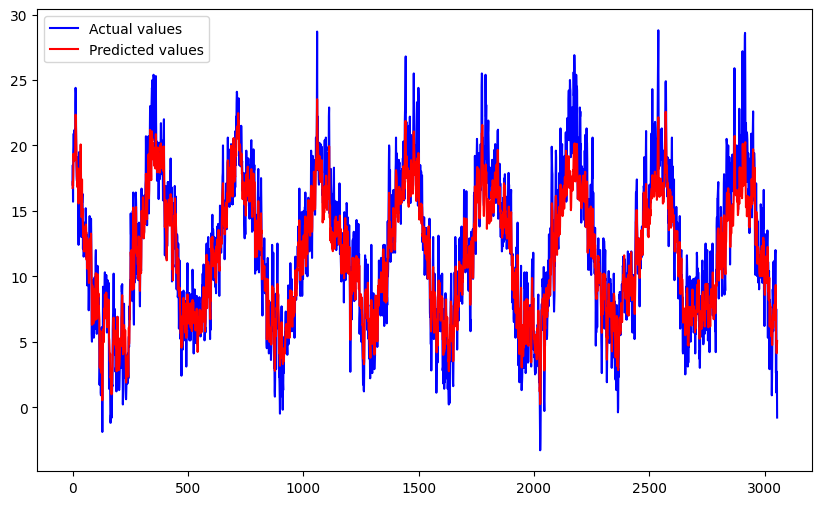

In [5]:
# Draw a comparison chart of predicted and actual values
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual values')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted values')
plt.legend()
plt.show()

##### 贝叶斯优化

In [6]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

# Define parameter space
space = {
    'C': hp.loguniform('C', np.log(1e-6), np.log(1e+6)),
    'gamma': hp.loguniform('gamma', np.log(1e-6), np.log(1e+1)),
    'kernel': hp.choice('kernel', ['rbf'])
}

# Define the objective function
def objective(params):
    model = SVR(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=3, n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

# run optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

print(best)


100%|██████████| 25/25 [50:43<00:00, 121.73s/trial, best loss: -0.9941554746564608]
{'C': 17342.384286955516, 'gamma': 1.641545121844323e-06, 'kernel': 0}


#### 遗传算法超参数优化

In [16]:
# Use the GPU if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_train_tensor = torch.from_numpy(np.array(y_train).reshape(-1, 1)).float().to(device)
y_test_tensor = torch.from_numpy(np.array(y_test).reshape(-1, 1)).float().to(device)

class SVRModel(nn.Module):
    def __init__(self):
        super(SVRModel, self).__init__()
        self.fc1 = nn.Linear(260, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_model(lr, weight_decay):
    model = SVRModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Add weight_decay

    for _ in range(100):  # Train for 10 epochs
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)

    return test_loss.item()


In [17]:
import random
from deap import base, creator, tools, algorithms
import numpy as np

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Hyperparameters ranges
lr_min, lr_max = 1e-6, 1e-1
weight_decay_min, weight_decay_max = 1, 1e+6

toolbox.register("attr_lr", random.uniform, lr_min, lr_max)
toolbox.register("attr_weight_decay", random.uniform, weight_decay_min, weight_decay_max)

toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_lr, toolbox.attr_weight_decay), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    lr, weight_decay = individual
    lr =abs(lr)
    weight_decay = abs(weight_decay) # take the absolute value
    weight_decay = max(weight_decay, 0) # and 0 take the maximum value
    test_loss = train_model(lr, weight_decay)  # Modify the train_model function to accept weight_decay
    return test_loss,

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=[(lr_max + lr_min) / 2, (weight_decay_max + weight_decay_min) / 2], 
                 sigma=[(lr_max - lr_min) / 3, (weight_decay_max - weight_decay_min) / 3], indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=30, 
                                       stats=stats, halloffame=hof, verbose=True)
    return pop, logbook, hof

if __name__ == "__main__":
    pop, log, hof = main()
    print("Best individual:", hof[0])
    print("Best fitness:", hof[0].fitness.values[0])


D:\Anaconda3\envs\deep_learning\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\Anaconda3\envs\deep_learning\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg        	std        	min    	max        
0  	50    	2.19327e+06	1.47918e+07	31.8854	1.05711e+08
1  	19    	317.216    	932.005    	31.8854	6098.79    
2  	30    	5469.23    	24280.3    	31.8854	164005     
3  	34    	669.315    	1591.9     	31.8854	8960.49    
4  	29    	1371.26    	5058.98    	31.8854	33381.1    
5  	32    	1164.87    	3555.47    	31.8854	18604.8    
6  	29    	169.568    	398.111    	31.8854	2453.16    
7  	31    	5730.61    	35971.5    	31.8854	257175     
8  	26    	383.933    	918.326    	31.8854	4341.81    
9  	33    	216.35     	613.433    	31.8854	4143.09    
10 	31    	516.366    	1579.63    	31.8854	9679.61    
11 	24    	707.71     	2388.61    	31.8854	11501.8    
12 	25    	2724.65    	15516.8    	31.8854	110325     
13 	22    	140.79     	363.57     	31.8854	1865.37    
14 	25    	1201.07    	7582.58    	31.8854	54189.6    
15 	36    	112.268    	252.624    	31.8854	1744.67    
16 	25    	421809     	2.95116e+06	31.8854	2.108e+07  
17 	27    

In [18]:


# define model
model = svm.SVR(C=1593915.6867873217, gamma=0.011164875128362266, kernel='rbf')

# Evaluate model performance using time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Using time series division, 5-fold
scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')  
print(f"Average MSE using Time Series Cross Validation: {-scores.mean()}")

# Train the model on the entire training data
model.fit(X_train_scaled, y_train)

# predict
y_pred = model.predict(X_test_scaled)

# Compute and print mean squared error, mean absolute error and R^2 score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, R^2 Score: {r2}, MSE:{mse}')

Average MSE using Time Series Cross Validation: 6.354668173092529
MAE: 2.2936976514229213, R^2 Score: 0.7142506077712168, MSE:9.155759992712689


#### 贝叶斯优化参数的SVR model

In [19]:
# define model
model = svm.SVR(C=17342.384286955516, gamma=1.641545121844323e-06, kernel='rbf')

# Evaluate model performance using time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Using time series division, 5-fold
scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')  
print(f"Average MSE using Time Series Cross Validation: {-scores.mean()}")


# Train the model on the entire training data
model.fit(X_train_scaled, y_train)

# predict
y_pred = model.predict(X_test_scaled)

# Compute and print mean squared error, mean absolute error and R^2 score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae}, R^2 Score: {r2}, MSE:{mse}')


Average MSE using Time Series Cross Validation: 1.2486876466467887
MAE: 0.9014503320364413, R^2 Score: 0.9556385071692151, MSE:1.421396483502998


#### 不同期限的预测精度，1天，3天，7天和14天-使用多元输出SVR

In [4]:
# Define the periods for forecasting
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
periods = [1, 3, 7, 14]
window_size=20
# Define a dictionary to store the models
models = {}

# Train a model for each period
for period in periods:
    print(f"Training model for a forecast period of {period} days...")

    # Prepare the features and the targets for the given forecast period
    features, targets = [], []
    for i in range(window_size, len(data_weather_encoded) - period):
        features.append(data_weather_encoded.iloc[i - window_size:i].values)
        targets.append(data_weather_encoded.iloc[i:i + period]['mean_temp'].values)
    features = np.array(features)
    targets = np.array(targets)

    # Split the data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    mul_svr = MultiOutputRegressor(SVR(C=17342.384286955516, gamma=1.641545121844323e-06, kernel='rbf'))
    mul_svr.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    # Save the model into the dictionary
    models[period] = mul_svr

    # Predict on the train and test sets
    y_train_pred = mul_svr.predict(X_train.reshape(X_train.shape[0], -1))
    y_test_pred = mul_svr.predict(X_test.reshape(X_test.shape[0], -1))

    # Evaluate the model
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"Period: {period} days, Train MSE: {mse_train}, Test MSE: {mse_test}, Train MAE: {mae_train}, Test MAE: {mae_test}, Train R^2: {r2_train}, Test R^2: {r2_test}")


Training model for a forecast period of 1 days...
Period: 1 days, Train MSE: 1.1266497763850374, Test MSE: 1.2649003573284596, Train MAE: 0.8116216100337764, Test MAE: 0.8548926316743162, Train R^2: 0.9654563724282675, Test R^2: 0.9611696846249287
Training model for a forecast period of 3 days...
Period: 3 days, Train MSE: 3.3219662832262116, Test MSE: 3.4918689449639664, Train MAE: 1.366852853068962, Test MAE: 1.413160947632418, Train R^2: 0.8980844705582823, Test R^2: 0.8928273204334035
Training model for a forecast period of 7 days...
Period: 7 days, Train MSE: 5.747993105204766, Test MSE: 6.027937816507746, Train MAE: 1.8304147893700977, Test MAE: 1.8933286598184849, Train R^2: 0.8239360239683124, Test R^2: 0.8132506839397282
Training model for a forecast period of 14 days...
Period: 14 days, Train MSE: 7.106513756484887, Test MSE: 7.568308139065954, Train MAE: 2.0690723223808236, Test MAE: 2.150293016319133, Train R^2: 0.780472190077389, Test R^2: 0.7725828127468971


In [5]:
def direct_prediction(model, data, scaler, period):

    
    # Standardize the data
    standardized_data = scaler.transform(data.reshape(1, -1))
    
    # Predict the values for the given period
    predictions = model.predict(standardized_data)
    
    return predictions[0]

# Use the function to predict for each period
last_data = data_weather_encoded.iloc[-window_size:].values.reshape(1, -1)

for period in periods:
    predictions = direct_prediction(models[period], last_data, scaler, period)
    print(f"Predictions for {period} days:", predictions)


Predictions for 1 days: [1.12982599]
Predictions for 3 days: [1.21708626 1.80750821 3.20496621]
Predictions for 7 days: [1.30958748 1.64365606 3.23840395 4.18150925 3.3056386  4.52080177
 5.84442195]
Predictions for 14 days: [1.08494809 1.11945141 3.44011946 4.5569188  3.2347923  4.26326212
 5.89384899 3.92419747 5.03320807 5.43179965 4.31930307 6.70791583
 5.66587518 6.19704778]


In [6]:
import pickle
with open('svr_predictions.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [7]:
import pickle

with open("svr_predictions.pkl", "rb") as file:
    predictions = pickle.load(file)

In [8]:
predictions

array([1.08494809, 1.11945141, 3.44011946, 4.5569188 , 3.2347923 ,
       4.26326212, 5.89384899, 3.92419747, 5.03320807, 5.43179965,
       4.31930307, 6.70791583, 5.66587518, 6.19704778])